# Chapter 14. Computer Vision

## Chapter 14.1 Image Augmentation

In [29]:
!pip install -U torch==2.0.0 torchvision==0.15.1
!pip install -U d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 127.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
d2l.set_figsize()
img = d2l.Image.open('img/cat1.jpg')
d2l.plt.imshow(img);

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

In [ ]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

In [ ]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

In [ ]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [ ]:
# Training with Image Augmentation

all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [ ]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs."""
    
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
        
    y = y.to(devices[0])
    
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs."""
    
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], 
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if(i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                            (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {metric[0] / metric[2]:.3f}, train acc ' 
         f'{metric[1] / metric[2]:.3f}, test acc {test_acc:.3f}')
    
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on ' 
         f'[str(devices)')        

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

In [ ]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
    

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

## Chapter 14.2 Fine-tuning

In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [ ]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [ ]:
# standardize each channel

normalize = torchvision.transforms.Normalize( 
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([ 
    torchvision.transforms.RandomResizedCrop(224), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(), 
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

In [ ]:
pretrained_net.fc

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [ ]:
# Finetuning the model

def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    
    if param_group:
        params_1x = [param for name, param in net.named_parameters() 
                    if name not in ['fc.weight', 'fc.bias']]
        trainer = torch.optim.SGD([{'params': params_1x},
                                  {'params': net.fc.parameters(),
                                  'lr': learning_rate * 10}],
                                 lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
        
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
    

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

## Chapter 14.3 Object Detection and Bouding Boxes

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [ ]:
d2l.set_figsize()
img = d2l.plt.imread('./img/catdog.jpg')
d2l.plt.imshow(img)

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)"""
    
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    
    x1 = cx - 0.5 * w
    x2 = cx + 0.5 * w
    y1 = cy - 0.5 * h
    y2 = cy + 0.5 * h
    
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    
    return boxes


In [ ]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

In [ ]:
def bbox_to_rect(bbox, color):
    """Converting bounding box to matplotlib format."""
    
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )


In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## Chapter 14.4 Anchor Boxes

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2) # simplify printing accuracy

In [ ]:
# Generating Multiple Anchor Boxes

def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    
    in_height, in_width = data.shape[-2:]

In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width
    
    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # Generate boxes_per_pixel number of heights and widths
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), 
                  sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), 
                  sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2
    
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                          dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    
    return output.unsqueeze(0)


In [ ]:
img = d2l.plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Showing bouding boxes."""
    
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                     va='center', ha='center', fontsize=9, color=text_color,
                     bbox=dict(facecolor=color, lw=0))
            

In [ ]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
           ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])


In [ ]:
# Intersection over Union (IoU)

def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * 
                             (boxes[:, 3] - boxes[:, 1]))
    
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    
    return inter_areas / union_areas



In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest groud-truth bounding boxes to anchor boxes."""
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    
    jaccard = box_iou(anchors, ground_truth)
    
    anchors_bbox_map = torch.full((num_anchors, ), -1, dtype=torch.long, device=device)
    
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors, ), -1)
    row_discard = torch.full((num_gt_boxes, ), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map


In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bouding boxes."""
    
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    
    return (bbox_offset, bbox_mask, class_labels)


In [ ]:
# An Example

ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], [1, 0.55, 0.2, 0.9, 0.88]])

anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4], 
                       [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8], 
                       [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);


In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [ ]:
# 结果与教材不同，哪里出问题了

labels[2], labels[1], labels[0]

### Chapter 14.4.4 Predicting Bounding Boxes with Non-Maximum Suppression

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predicting bounding boxes based on anchor boxes with predicted offsets."""
    
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    
    return predicted_bbox


In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), 
                     boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        
    return torch.tensor(keep, device=boxes.device)


In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1), 
                              conf.unsqueeze(1), 
                              predicted_bb), dim=1)
        out.append(pred_info)
        
    return torch.stack(out)

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], 
                       [0.08, 0.2, 0.56, 0.95], 
                       [0.15, 0.3, 0.62, 0.91], 
                       [0.55, 0.2, 0.9, 0.88]])

offset_preds = torch.tensor([0] * anchors.numel())

cls_probs = torch.tensor([[0] * 4,
                        [0.9, 0.8, 0.7, 0.1],
                        [0.1, 0.2, 0.3, 0.9]])


In [ ]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, 
           ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                           offset_preds.unsqueeze(dim=0),
                           anchors.unsqueeze(dim=0),
                           nms_threshold=0.5)
output

In [ ]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

## Chapter 14.5 Multiscale Object Detection

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]
h, w

In [ ]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

In [ ]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

In [ ]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

In [ ]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## Chapter 14.6 The Object Detection Dataset

In [ ]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip', 
    '5de26c8fce5ccdea9f91267273464dc968d20d72')


In [ ]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
        
    return images, torch.tensor(targets).unsqueeze(1) / 256
    

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
        
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)
    

In [ ]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                            batch_size, shuffle=True)
    
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    
    return train_iter, val_iter


In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

In [ ]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Chapter 14.7 Single Shot Multibox Detection

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [ ]:
def forward(x, block):
    return block(x)

In [ ]:
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [ ]:
concat_preds([Y1, Y2]).shape

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
        
    blk.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*blk)

In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)


In [ ]:
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
        
    return blk

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement of self.blk_i = get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
            
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        
        return anchors, cls_preds, bbox_preds
    

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)


In [ ]:
# Chapter 14.7.2 Training

batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

In [ ]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    
    return cls + bbox

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension, argmax needs to specify this dimension
    
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [ ]:
# Training the model

num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])

net = net.to(device)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(), 
                  bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel())
    
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
    
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
     f'{str(device)}')

In [ ]:
# Prediction

X = torchvision.io.read_image('./img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
        

In [ ]:
display(img, output.cpu(), threshold=0.9)

## Chapter 14.8 Region-based CNNs (R-CNNs)

In [ ]:
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
X

In [ ]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

In [ ]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

* The R-CNN extracts many region proposals from the input image, uses a CNN to perform forward propagation on each region proposal to extract its features, then uses these features to predict the class and bounding box of this region proposal.

* One of the major improvements of the fast R-CNN from the R-CNN is that the CNN forward propagation is only performed on the entire image. It also introduces the region of interest pooling layer, so that features of the same shape can be further extracted for regions of interest that have different shapes.

* The faster R-CNN replaces the selective search used in the fast R-CNN with a jointly trained region proposal network, so that the former can stay accurate in object detection with a reduced number of region proposals.

* Based on the faster R-CNN, the mask R-CNN additionally introduces a fully convolutional network, so as to leverage pixel-level labels to further improve the accuracy of object detection.

## Chapter 14.9 Semantic Segmentation and the Dataset

In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                          '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                            'train.txt' if is_train else 'val.txt')
    
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
        voc_dir, 'JPEGImages', f'{fname}.jpg'), mode))
        
        labels.append(torchvision.io.read_image(os.path.join(
        voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
        
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

In [ ]:
len(train_labels), len(train_features)

In [ ]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
               [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
               [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
               [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicyle', 'bird', 'boat',
              'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
              'diningtable', 'dog', 'horse', 'motorbike', 'person',
              'potted platn', 'sheep', 'sofa', 'train', 'tv/monitor']


In [ ]:
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]
        ] = i
        
    return colormap2label


In [ ]:
def voc_label_indices(colormap, colormap2label):
    """Map any RGB value in VOC labels to their class indices."""
    
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
          + colormap[:, :, 2])
    
    return colormap2label[idx]


In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

In [ ]:
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
    
imgs = [img.permute(1, 2, 0) for img in imgs]

d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [ ]:
# Custom semantic segmentation dataset class

class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to laod the VOC dataset."""
    
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
        
    def normalize_image(self, img):
        return self.transform(img.float() / 255)
    
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and 
            img.shape[2] >= self.crop_size[1])]
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [ ]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

In [ ]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True,
                                        num_workers=d2l.get_dataloader_workers())

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

In [ ]:
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2021'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    
    return train_iter, test_iter

## Chapter 14.10 Transposed Convolution

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h -1, X.shape[1] + w - 1))
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
            
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

In [ ]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

In [ ]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

In [ ]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

In [ ]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

* In contrast to the regular convolution that reduces input elements via the kernel, the transposed convolution broadcasts input elements via the kernel, thereby producing an output that is larger than the input.

## 14.11 Fully Convolutional Networks

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [4]:
# It copies all the pretrained layers in the ResNet-18 
# except for the final global average pooling layer and 
# the fully connected layer that are closest to the output.

net = nn.Sequential(*list(pretrained_net.children()))[:-2]

In [5]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [6]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, 
                                                    kernel_size=64, padding=16, stride=32))

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    
    og = (torch.arange(kernel_size).reshape(-1, 1),
         torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    
    return weight

In [8]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [9]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape:  torch.Size([561, 728, 3])
output image shape:  torch.Size([1122, 1456, 3])


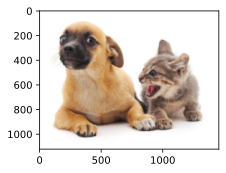

In [10]:
d2l.set_figsize()
print('input image shape: ', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape: ', out_img.shape)
d2l.plt.imshow(out_img)

In [11]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [12]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [ ]:
# will kill kernel? failed to run this time. 2024.2.24
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [3]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [4]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

In [5]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1, 2, 0), pred.cpu(),
            torchvision.transforms.functional.crop(
                test_labels[i], *crop_rect).permute(1, 2, 0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

NameError: name 'test_iter' is not defined

* The fully convolutional network first uses a CNN to extract image features, then transforms the number of channels into the number of classes via a convolutional layer, and finally transforms the height and width of the feature maps to those of the input image via the transposed convolution.

## Chapter 14.12 Neural Style Transfer

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

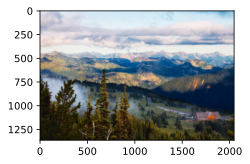

In [2]:
d2l.set_figsize()
content_img = d2l.Image.open('img/rainier.jpg')
d2l.plt.imshow(content_img)

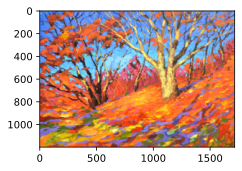

In [3]:
style_img = d2l.Image.open('img/autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [5]:
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [6]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [8]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                     range(max(content_layers + style_layers) + 1)])

In [9]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
            
    return contents, styles

In [10]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


In [11]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

In [12]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [13]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [14]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
                 torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [15]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [16]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
        
    def forward(self):
        return self.weight

In [17]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [18]:
# Start training

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                           xlim=[10, num_epochs],
                           legend=['content', 'style', 'TV'],
                           ncols=2, figsize=(7, 2.5))
    
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if(epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                    float(sum(styles_l)), float(tv_l)])
    return X

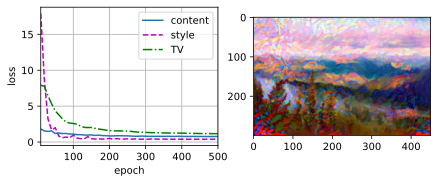

In [19]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

## Chapter 14.13 Image Classification (CIFAR-10) on Kaggle

In [21]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

*  In this section, we will apply the knowledge we learned in previous sections to practice the Kaggle competition of CIFAR-10 image classification. The web address of the competition is https://www.kaggle.com/c/cifar-10

In [22]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                               '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# if use full cifar-10 dataset, please set demo variable to false.

demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10'
    

In [23]:
def read_csv_labels(fname):
    """Read fname to return a filename to label dictionary."""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


In [28]:
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
    
def reorg_train_valid(data_dir, labels, valid_ratio):
    """Split the validation set out of the original training set."""
    
    n = collections.Counter(labels.values()).most_common()[-1][1]
    
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    
    label_count = {}
    
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    
    return n_valid_per_label 

In [25]:
def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction."""
    
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [26]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [29]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [34]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                           ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                    [0.2023, 0.1994, 0.2010])
])

In [35]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                    [0.2023, 0.1994, 0.2010])
])

In [36]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [44]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
                               for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [38]:
# define the model

def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [41]:
def train(net, trainer_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (metric[0] / metric[2], metric[1] / metric[2], None))
        
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        
        scheduler.step()
        
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
               f'train acc {metric[1] / metric[2]:.3f}')
    
    
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
         f' examples/sec on {str(devices)}')

train loss 0.606, train acc 0.789, valid acc 0.422
1104.9 examples/sec on [device(type='cuda', index=0)]


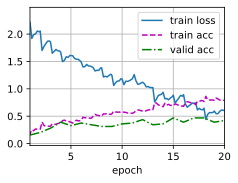

In [42]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.575, train acc 0.810
1108.8 examples/sec on [device(type='cuda', index=0)]


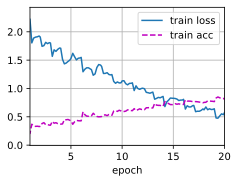

In [45]:
net, preds = get_net(), []
net(next(iter(train_valid_iter))[0])
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
    
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

## Chapter 14.14 Dog Breed Identification (ImageNet Dogs) on Kaggle

In [62]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [63]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip', 
                           '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = True

if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [64]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)
    
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [65]:
# Image Augmentation

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                            ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4, 
                                      contrast=0.4, 
                                      saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
])

In [66]:
tranform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
])

In [67]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [68]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
                               for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [69]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 120))
    
    finetune_net = finetune_net.to(devices[0])
    
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    
    return finetune_net

In [70]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    
    return l_sum / n

In [71]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    
    # Only train the small custom output network
    
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                             if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    
    if valid_iter is not None:
        legend.append('valid loss')
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if(i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
        
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}' 
          f' examples/sec on {str(devices)}')

RuntimeError: stack expects each tensor to be equal size, but got [3, 250, 267] at entry 0 and [3, 352, 500] at entry 1

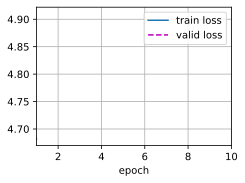

In [72]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.988
675.1 examples/sec on [device(type='cuda', index=0)]


RuntimeError: stack expects each tensor to be equal size, but got [3, 301, 400] at entry 0 and [3, 500, 376] at entry 1

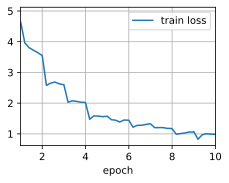

In [73]:
# Classifying for Test set

net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

preds = []

for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
    
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unkown')))

with open('submission.csv', 'w') as f:
    f.write('id, ' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')